### Canny Edge Detection


In [373]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [374]:
FOLDER = '../data/'
FILE = 'clown.jpeg'

clown_image = cv.imread(os.path.join(FOLDER, FILE)) # BGR

In [375]:
def convert_to_grayscale(image) -> np.ndarray:
    """
    Convert image to grayscale using OpenCV
    """
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

def convert_to_grayscale_manual(image) -> np.ndarray:
    """
    Convert image to grayscale manually

    Formula: Y = 0.299*R + 0.587*G + 0.114*B
    Image: (RGB) image
    """
    return 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]

In [376]:
def apply_gaussian_blur(image, kernel_size, sigma) -> np.ndarray:
    """
    Apply Gaussian Blur to the image using OpenCV
    """
    return cv.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def apply_gaussian_blur_manual(image, kernel_size, sigma) -> np.ndarray:
    """
    Apply Gaussian Blur to the image manually
    """
    kernel = cv.getGaussianKernel(kernel_size, sigma)
    kernel = kernel * kernel.T
    return cv.filter2D(image, -1, kernel)

In [377]:
def apply_sobel(image) -> tuple[np.ndarray, np.ndarray]:
    """
    Apply Sobel filter to the image
    """
    sobel_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=5)
    sobel_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=5)
    return sobel_x, sobel_y

def apply_sobel_manual(image) -> tuple[np.ndarray, np.ndarray]:
    """
    Apply Sobel filter to the image manually
    """
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    sobel_x = cv.filter2D(image, -1, kernel_x)
    sobel_y = cv.filter2D(image, -1, kernel_y)
    return sobel_x, sobel_y

def get_gradient_magnitude_direction(sobel_x, sobel_y) -> tuple[np.ndarray, np.ndarray]:
    """
    Get magnitude and direction of the gradient
    """
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2) # sqrt(x^2 + y^2)
    direction = np.arctan2(sobel_y, sobel_x) # tan inverse (y/x)
    return magnitude, direction

In [378]:
def non_maximum_suppression_pixel(magnitude, direction, i, j) -> float:
    """
    Non-maximum suppression for a pixel
    """
    angle = direction[i, j] * 180. / np.pi
    angle = angle % 180

    q, r = 255, 255
    # Angle 0
    if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
        q = magnitude[i, j+1] # Right
        r = magnitude[i, j-1] # Left
    # Angle 45
    elif (22.5 <= angle < 67.5):
        q = magnitude[i+1, j-1] # Bottom Left
        r = magnitude[i-1, j+1] # Top Right
    # Angle 90
    elif (67.5 <= angle < 112.5):
        q = magnitude[i+1, j] # Bottom
        r = magnitude[i-1, j] # Top
    # Angle 135
    elif (112.5 <= angle < 157.5):
        q = magnitude[i-1, j-1] # Top Left
        r = magnitude[i+1, j+1] # Bottom Right

    # Suppress pixel if it is not the maximum
    if (magnitude[i, j] >= q) and (magnitude[i, j] >= r):
        return magnitude[i, j]
    else:
        return 0

def non_maximum_suppression(magnitude, direction) -> np.ndarray:
    """
    Non-maximum suppression
    """
    rows, cols = magnitude.shape
    result = np.zeros((rows, cols), dtype=np.float32)

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            result[i, j] = non_maximum_suppression_pixel(magnitude, direction, i, j)

    return result

In [379]:
def single_thresholding(image, threshold):
    """
    Single thresholding
    """
    result = np.zeros_like(image)
    result[image > threshold] = 255
    return result

In [380]:
def add_subplot(image, title, rows, cols, index, cmap=None):
    """
    Add subplot to the figure
    """
    plt.subplot(rows, cols, index)
    plt.imshow(image, cmap)
    plt.title(title)
    plt.axis('off')

In [381]:
def canny_edge_detector(image, kernel_size, sigma) -> np.ndarray:
    """
    Canny Edge Detector
    """
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 8))
    add_subplot(image, 'Original Image', 3, 3, 1)

    # Step 1: Convert to grayscale
    gray = convert_to_grayscale_manual(image)
    add_subplot(gray, 'Grayscale Image', 3, 3, 2, cmap='gray')

    # Step 2: Apply Gaussian Blur
    blurred = apply_gaussian_blur_manual(gray, kernel_size, sigma)
    add_subplot(blurred, f'Gaussian Blur, Kernel Size: {(kernel_size, kernel_size)}, Sigma: {sigma}', 3, 3, 3, cmap='gray')

    # Step 3: Apply Sobel filter
    sobel_x, sobel_y = apply_sobel_manual(blurred)
    add_subplot(sobel_x, 'Sobel X', 3, 3, 4, cmap='gray')
    add_subplot(sobel_y, 'Sobel Y', 3, 3, 5, cmap='gray')

    # Step 4: Get gradient magnitude and direction
    magnitude, direction = get_gradient_magnitude_direction(sobel_x, sobel_y)
    add_subplot(magnitude, 'Gradient Magnitude', 3, 3, 6, cmap='gray')
    add_subplot(direction, 'Gradient Direction', 3, 3, 7, cmap='gray')

    # Step 5: Non-maximum suppression
    non_max = non_maximum_suppression(magnitude, direction)
    add_subplot(non_max, 'Non-Maximum Suppression', 3, 3, 8, cmap='gray')

    # Step 6: Single thresholding
    threshold = np.median(magnitude)
    thresholded = single_thresholding(non_max, threshold)
    add_subplot(thresholded, "Single Thresholding {:.2f}".format(threshold), 3, 3, 9, cmap='gray')
    plt.show()

    return thresholded, kernel_size, sigma

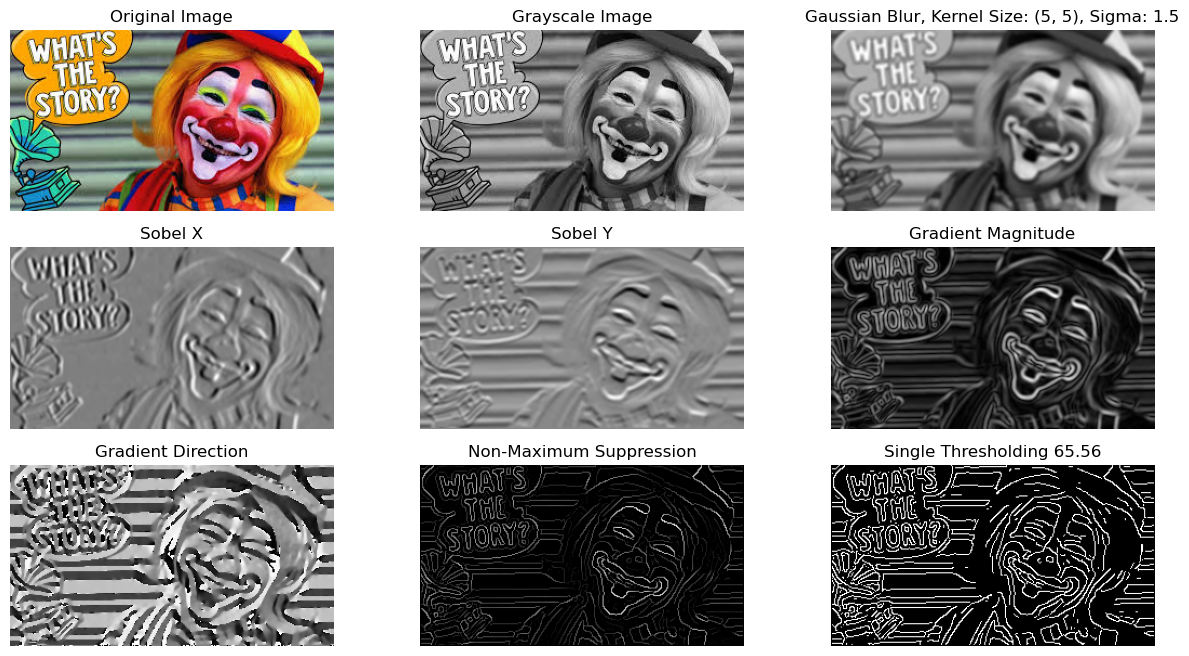

In [382]:
final_image, _, _ = canny_edge_detector(clown_image, 5, 1.5) # Kernel size: 5, Sigma: 1.5

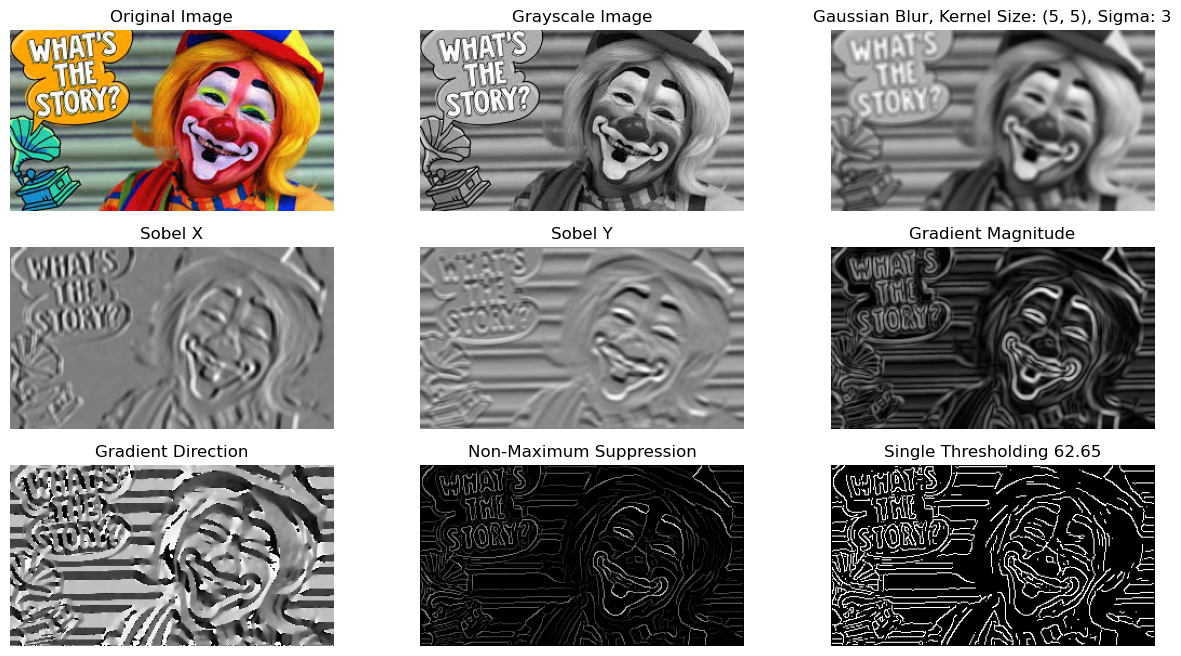

In [383]:
final_image_2, _, _ = canny_edge_detector(clown_image, 5, 3) # Kernel size: 5, Sigma: 3

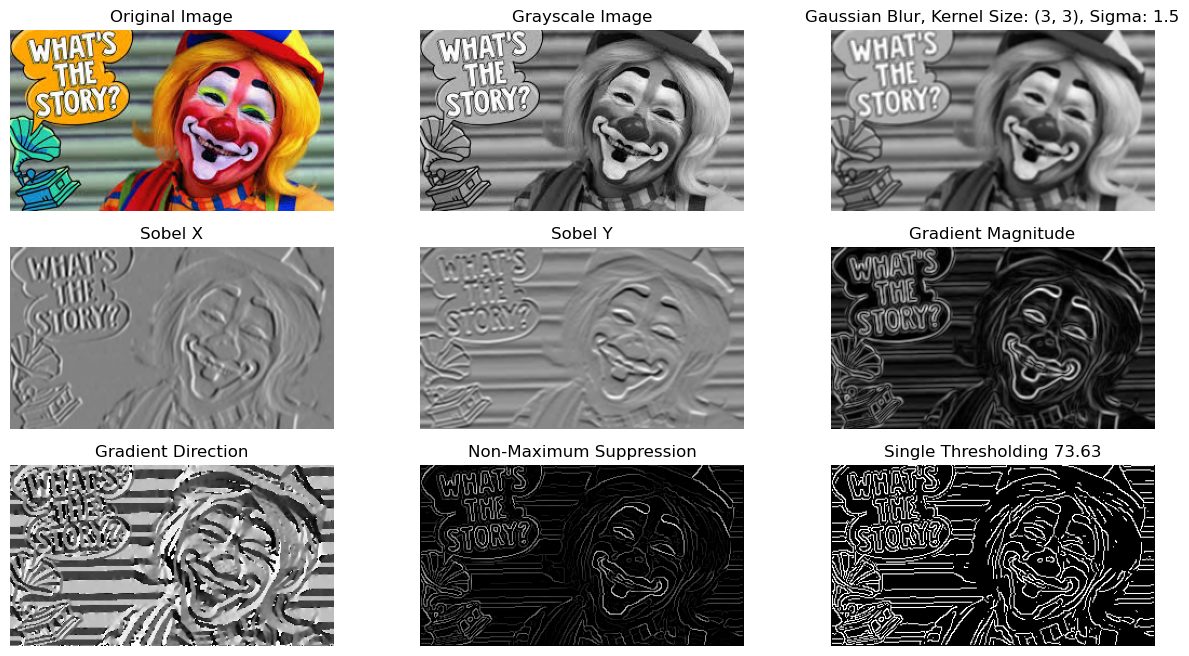

In [384]:
final_image_3, _, _ = canny_edge_detector(clown_image, 3, 1.5) # Kernel size: 3, Sigma: 1.5

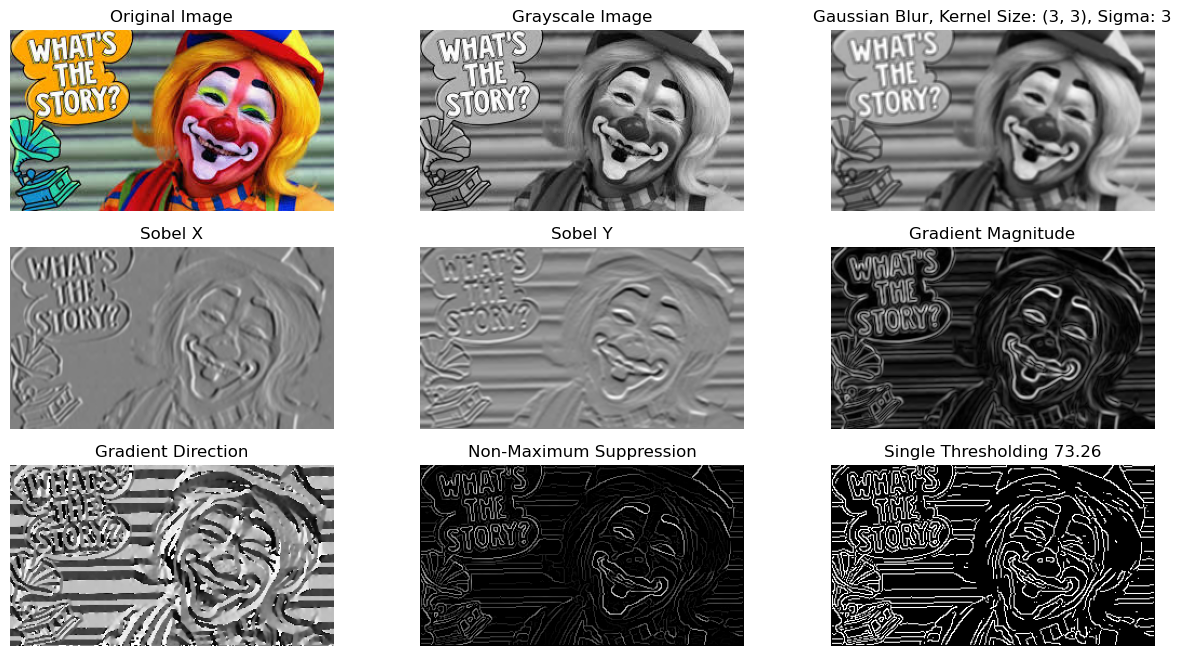

In [385]:
final_image_4, _, _ = canny_edge_detector(clown_image, 3, 3) # Kernel size: 3, Sigma: 3

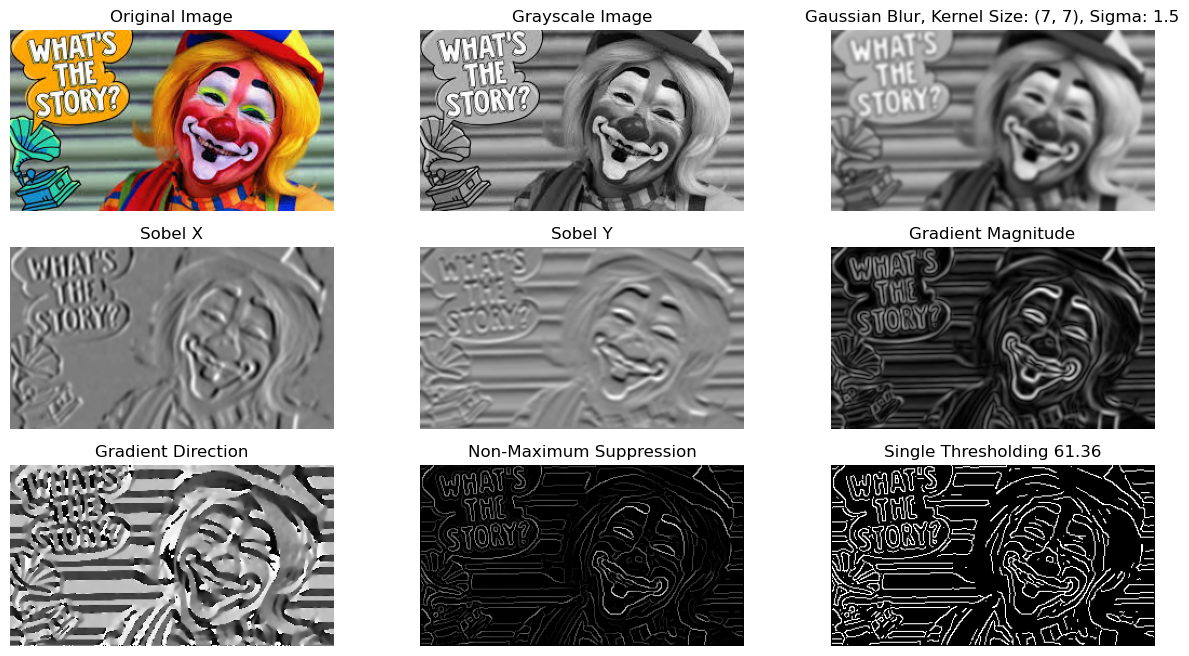

In [386]:
final_image_5, _, _ = canny_edge_detector(clown_image, 7, 1.5) # Kernel size: 7, Sigma: 1.5

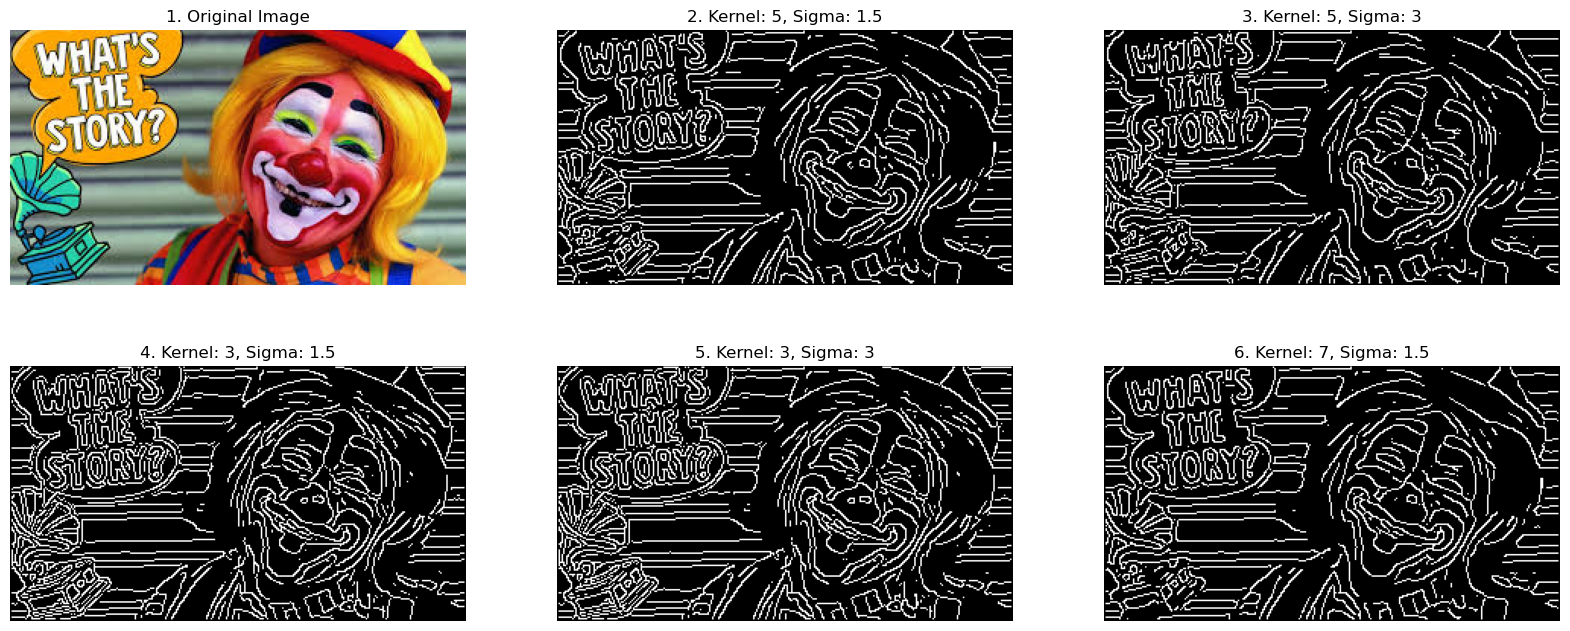

In [387]:
plt.figure(figsize=(20, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv.cvtColor(clown_image, cv.COLOR_BGR2RGB))
plt.title('1. Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(final_image, cmap='gray')
plt.title('2. Kernel: 5, Sigma: 1.5')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(final_image_2, cmap='gray')
plt.title('3. Kernel: 5, Sigma: 3')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(final_image_3, cmap='gray')
plt.title('4. Kernel: 3, Sigma: 1.5')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(final_image_4, cmap='gray')
plt.title('5. Kernel: 3, Sigma: 3')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(final_image_5, cmap='gray')
plt.title('6. Kernel: 7, Sigma: 1.5')
plt.axis('off')

plt.savefig('canny_edge_detector.png')
plt.show()

### Kernel Size = 5 & Sigma = 3 vs 1.5

1. Let's look at the letters in the image 2 and 3 above, we can see that the **edges are more prominant** in the image with sigma 1.5 as its less blurred compared to the image with sigma 3.

2. **More edges are detected** in the image with sigma 1.5 compared to the image with sigma 3.

3. **The length of the edges detected are longer** in the image with sigma 1.5 compared to the image with sigma 3.